# CAR-T CD8 T cell Analysis

In [368]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pickle as pkl
import scipy.sparse as sparse
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [369]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento

In [370]:
data_path = '/data_volume/memento/cart/'

### Read the data

In [414]:
def reverse_engineer_counts(adata, n_counts_column='n_counts'):
	
    n_counts = adata.obs[n_counts_column].values
    normed_sum = np.round(adata.raw.X.expm1().sum(axis=1)[0,0])

    counts = sparse.diags(n_counts/normed_sum)*adata.raw.X.expm1()

    return sc.AnnData(
        X=counts,
        obs=adata.obs,
        var=adata.raw.var)

In [415]:
def setup_data(fname):
    
    adata = reverse_engineer_counts(sc.read(data_path + fname))
    adata.obs['response_binary'] = (adata.obs['response']=='DR').astype(int)
    filtered_patients = adata.obs['patient'].value_counts()
    filtered_patients = filtered_patients[filtered_patients > 300].index.tolist()
    adata = adata[adata.obs.patient.isin(filtered_patients)].copy().copy()
    
    return adata

In [416]:
cd8_adata = setup_data('adata_early_CAR_CD8.h5ad')

In [417]:
cd4_adata = setup_data('adata_early_CAR_CD4.h5ad')

### (Optional) Randomize the durable vs transient lables

In [418]:
# patient_label_match = adata.obs[['patient', 'response_binary']].drop_duplicates()
# patient_label_match['response_binary_shuffled'] = np.random.choice(patient_label_match['response_binary'], patient_label_match.shape[0], replace=True)

In [419]:
# new_obs = adata.obs.merge(patient_label_match, on='patient')
# new_obs.index = adata.obs.index
# adata.obs = new_obs

### Run memento

In [420]:
%env PYTHONWARNINGS=ignore::RuntimeWarning

env: PYTHONWARNINGS=ignore::RuntimeWarning


In [421]:
def run_memento(adata):
    
    adata.obs['capture_rate'] = 0.1
    memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.001, estimator_type='mean_only')
    memento.create_groups(adata, label_columns=['patient','response_binary'])
    memento.compute_1d_moments(adata, min_perc_group=0.7)

    sample_meta = pd.get_dummies(memento.get_groups(adata), drop_first=True)
    treatment = sample_meta[['response_binary']]

    memento.ht_1d_moments(
        adata, 
        treatment=treatment,
        covariate=covariate,
        num_boot=10000, 
        verbose=1,
        num_cpus=90,
        resampling='bootstrap',
        approx=True,
        resample_rep=True)

    result = memento.get_1d_ht_result(adata)
    result['fdr'] = memento.util._fdrcorrect(result['de_pval'])
    
    return result

In [422]:
cd4_result = run_memento(cd4_adata)

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  21 tasks      | elapsed:    6.4s
[Parallel(n_jobs=90)]: Done 271 tasks      | elapsed:    8.0s
[Parallel(n_jobs=90)]: Done 621 tasks      | elapsed:   10.4s
[Parallel(n_jobs=90)]: Done 1071 tasks      | elapsed:   13.4s
[Parallel(n_jobs=90)]: Done 1621 tasks      | elapsed:   16.9s
[Parallel(n_jobs=90)]: Done 2271 tasks      | elapsed:   21.3s
[Parallel(n_jobs=90)]: Done 3021 tasks      | elapsed:   26.3s
[Parallel(n_jobs=90)]: Done 3871 tasks      | elapsed:   32.1s
[Parallel(n_jobs=90)]: Done 4821 tasks      | elapsed:   38.1s
[Parallel(n_jobs=90)]: Done 5871 tasks      | elapsed:   44.7s
[Parallel(n_jobs=90)]: Done 7021 tasks      | elapsed:   52.6s
[Parallel(n_jobs=90)]: Done 8271 tasks      | elapsed:  1.0min
[Parallel(n_jobs=90)]: Done 9621 tasks      | elapsed:  1.2min
[Parallel(n_jobs=90)]: Done 11071 tasks      | elapsed:  1.3min
[Parallel(n_jobs=90)]: Done 11920 out of 11

In [423]:
cd8_result = run_memento(cd8_adata)

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    0.6s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:    6.3s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:   14.1s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:   25.3s
[Parallel(n_jobs=90)]: Done 1620 tasks      | elapsed:   37.7s
[Parallel(n_jobs=90)]: Done 2270 tasks      | elapsed:   53.6s
[Parallel(n_jobs=90)]: Done 3020 tasks      | elapsed:  1.2min
[Parallel(n_jobs=90)]: Done 3870 tasks      | elapsed:  1.5min
[Parallel(n_jobs=90)]: Done 4820 tasks      | elapsed:  1.9min
[Parallel(n_jobs=90)]: Done 5870 tasks      | elapsed:  2.2min
[Parallel(n_jobs=90)]: Done 7020 tasks      | elapsed:  2.7min
[Parallel(n_jobs=90)]: Done 8270 tasks      | elapsed:  3.2min
[Parallel(n_jobs=90)]: Done 9620 tasks      | elapsed:  3.7min
[Parallel(n_jobs=90)]: Done 11070 tasks      | elapsed:  4.3min
[Parallel(n_jobs=90)]: Done 11773 out of 11

### Plots

In [434]:
cd4_result.to_csv(data_path + 'cd4_result.csv')
cd8_result.to_csv(data_path + 'cd8_result.csv')

In [435]:
merged_result = cd4_result.merge(cd8_result, on='gene', suffixes=('_cd4', '_cd8'))

In [436]:
stats.pearsonr(merged_result['de_coef_cd8'], merged_result['de_coef_cd4'])

(0.46060617450584773, 0.0)

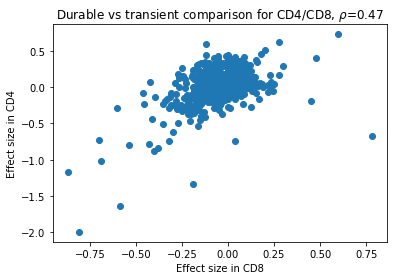

In [438]:
plt.scatter(merged_result['de_coef_cd8'], merged_result['de_coef_cd4'])
plt.xlabel('Effect size in CD8'); plt.ylabel('Effect size in CD4')
plt.title(r'Durable vs transient comparison for CD4/CD8, $\rho$=0.47')
plt.savefig('cd4_cd8_effect_sizes.png', bbox_inches='tight', dpi=300)